<a href="https://colab.research.google.com/github/D-Beall/MachineLearning/blob/master/Facial_Feature_Detection_w_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Libraries

In [12]:
import cv2
import numpy as np
import dlib # Load the detector
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
import seaborn as sb
from random import randint
from sklearn import metrics, model_selection
import sklearn.model_selection as skm
import sklearn.metrics as skmt
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

#import math

#Set path variable and import shape predictor.

In [13]:
path = "/content/drive/MyDrive/Colab Notebooks/face_project/"

detector = dlib.get_frontal_face_detector()# Load the predictor
predictor = dlib.shape_predictor(path + "shape_predictor_68_face_landmarks.dat")
images = []

# Image reading function: imagein(path_to_image)


In [14]:
# function to read each image
def imagein(path_to_image):
  '''
  Imports the jpg or jpeg image provided using OpenCV
  path_to_image: the file path

  returns points: (x,y) for landmarks
          img: image matrix (?)
  '''
    
  img = cv2.imread(path_to_image)
  # Convert image into grayscale
  gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
  # Use detector to find landmarks
  faces = detector(gray)
  points = []
  for face in faces:
      # Create landmark object
      landmarks = predictor(image=gray, box=face)
      #xn=[]
      #yn=[]
      # Loop through all the points
      for n in range(0, 68):
          x = landmarks.part(n).x
          y = landmarks.part(n).y
          points.append((x,y))
          # Draw a circle
          cv2.circle(img=img, center=(x, y), radius=1, color=(0, 255, 0), thickness=-1)
          #xn.append(x)
          #yn.append(y)
  return points, img

# Feature engineering

## measure asymmetry function: LIfeatures
extract within-hemiface distances from right and left landmarks, based on provided list of left and right landmarks, according to numbering by by OpenCV framework (Uses the functions points,mat= imagein("face.jpg") defined above)
Then normalizes and calculates laterality index for each pair of homologous feature. 
abs(LI) will put all asymmetries in the same side and make it a better input for SVM.

In [15]:
def LIfeatures(face_image,Llandmarks,Rlandmarks):
    '''
    function to extract all possible distances from right and left landmarks,
    extracted by OpenCV framework (Uses the functions points,mat= imagein("face.jpg"))
    
    Requires scipy.distance
    face_image is a jpg, jpeg, png frontal face image
    Llandmarks are the points that are consdiered Left face (of the person) and midline
    Rlandmarks are the points that are consdiered Right face (of the person) and midline
    
    1- extracts all distance as a distance matrix, separate right and left
    2- calculates intertemple distance for normalization
    3- after normalization, calculate laterality index. 
    Returns 
    
    defaults should be this but can be shortened to decrease dimentionality:
    map: https://miro.medium.com/max/518/0*L5z5AX73DUEl5klI.png 
    L=[16,15,14,13,12,11,10,9,8,26,25,24,23,22,27,28,29,30,35,34,33,45,44,43,42,47,46,54,53,52,51,57,56,55,64,63,62,66,65]
    R=[0,1,2,3,4,5,6,7,8,17,18,19,20,21,27,28,29,30,31,32,33,36,37,38,39,40,41,48,49,50,51,57,58,59,60,61,62,66,67]

    '''
    # import points, ignores the image matrix
    points,_=imagein(face_image)
    # inter-temple distance (0 to 16) as a normalization factor
    intertemple=distance.pdist([points[0], points[16]],'euclidean')
    # select left and right points
    Lpoints=[points[i] for i in Llandmarks]
    Rpoints=[points[i] for i in Rlandmarks]
    # Calculate Euclidean distannce, normalize by dividing on inter-temple distance.
    Ldistmat= distance.cdist(Lpoints, Lpoints,'euclidean')/intertemple
    Rdistmat= distance.cdist(Rpoints, Rpoints,'euclidean')/intertemple
    # Calculate the laterality index, take cares of divisions on zero and negative values
    LIdistmat=np.absolute(np.divide((Ldistmat-Rdistmat),(Ldistmat+Rdistmat),out=np.zeros_like(Ldistmat), where=Ldistmat!=0))
    LIvector=distance.squareform(LIdistmat)
    return LIvector, LIdistmat



# Tabulate features from all subjects in a directory
## function: Newgetdirfeatures

goes through the folder (path_to_directory) and tabulates all the features.


In [16]:
def Newgetdirfeatures(path_to_directory,label,L,R):

    '''
    get the path to directory/folders with images .
    returns a pandas dataframe with group label at first column, and calculated features

    ''' 
    # First control directory
    faceaddFeats=pd.DataFrame()
    for filename in os.listdir(path_to_directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            face=os.path.join(path_to_directory, filename)
        else:
            continue
        try:
            LIvector, LImatrix= LIfeatures(face,L,R)
            faceadd= np.transpose(pd.DataFrame(LIvector))
            faceaddFeats=pd.concat([faceaddFeats, faceadd], ignore_index=True)
            
        except IndexError:
            pass
    labelseries=pd.Series([label for x in range(len(faceaddFeats.index))])
    faceaddFeats.insert(0,'group',labelseries)

    
    return faceaddFeats

# Implementing feature extraction, normalization, and engineering 
## create dataset to train and test learning models
Goes through the patient folder and the healthy controls (mixed male and females from Camera C1, from the GUFD dataset).

In [17]:
# set path for two groups
droop_directory = r'/content/drive/MyDrive/Colab Notebooks/face_project/droopy'
control_directory = r'/content/drive/MyDrive/Colab Notebooks/face_project/control_C1'

# for debug and figures
test_directory=r'/content/drive/MyDrive/Colab Notebooks/face_project/test'
#os.listdir(droop_directory)
#face=os.path.join(droop_directory,'downlo.jpg')
#points, image= imagein(face)


In [18]:
# list of all points for classification to right and left
Llandmarks=[16,15,14,13,12,11,10,9,8,26,25,24,23,22,27,28,29,30,35,34,33,45,44,43,42,47,46,54,53,52,51,57,56,55,64,63,62,66,65]
Rlandmarks=[0,1,2,3,4,5,6,7,8,17,18,19,20,21,27,28,29,30,31,32,33,36,37,38,39,40,41,48,49,50,51,57,58,59,60,61,62,66,67]

dfpatients= Newgetdirfeatures(droop_directory,1,Llandmarks, Rlandmarks)
dfcontrols= Newgetdirfeatures(control_directory,0, Llandmarks, Rlandmarks)
df=pd.concat([dfcontrols,dfpatients],ignore_index=True)
dfpatients.shape


(297, 742)

In [19]:
dfpatients.shape

(297, 742)

In [20]:
dfcontrols.shape

(304, 742)

# Laterality Matrix example for one person. 
A 39 x 39 matrix represent the laterality index of different measures on one hemiface.
Many measures are highly symmetric (LI close to 0), while others are naturally asymmetric even in healthy control example.

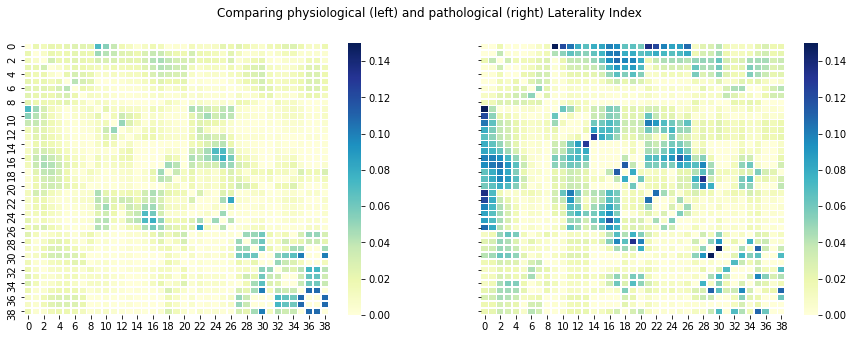

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Comparing physiological (left) and pathological (right) Laterality Index')

face1=test_directory+"/C1.jpg"
_, LImatrix= LIfeatures(face1,Llandmarks,Rlandmarks)
# LImatrix visualization for one person
ax=sb.heatmap(LImatrix,ax=ax1, vmax=.150, cbar=True, fmt="d", linewidths=.5, cmap="YlGnBu")

face2=test_directory+"/877.jpg"
_, LImatrix= LIfeatures(face2,Llandmarks,Rlandmarks)
# LImatrix visualization for one person
ax=sb.heatmap(LImatrix, ax=ax2,vmax=.150, cbar=True, fmt="d", linewidths=.5, cmap="YlGnBu")


# Visulization of features with highest asymmetry for patients in feature space

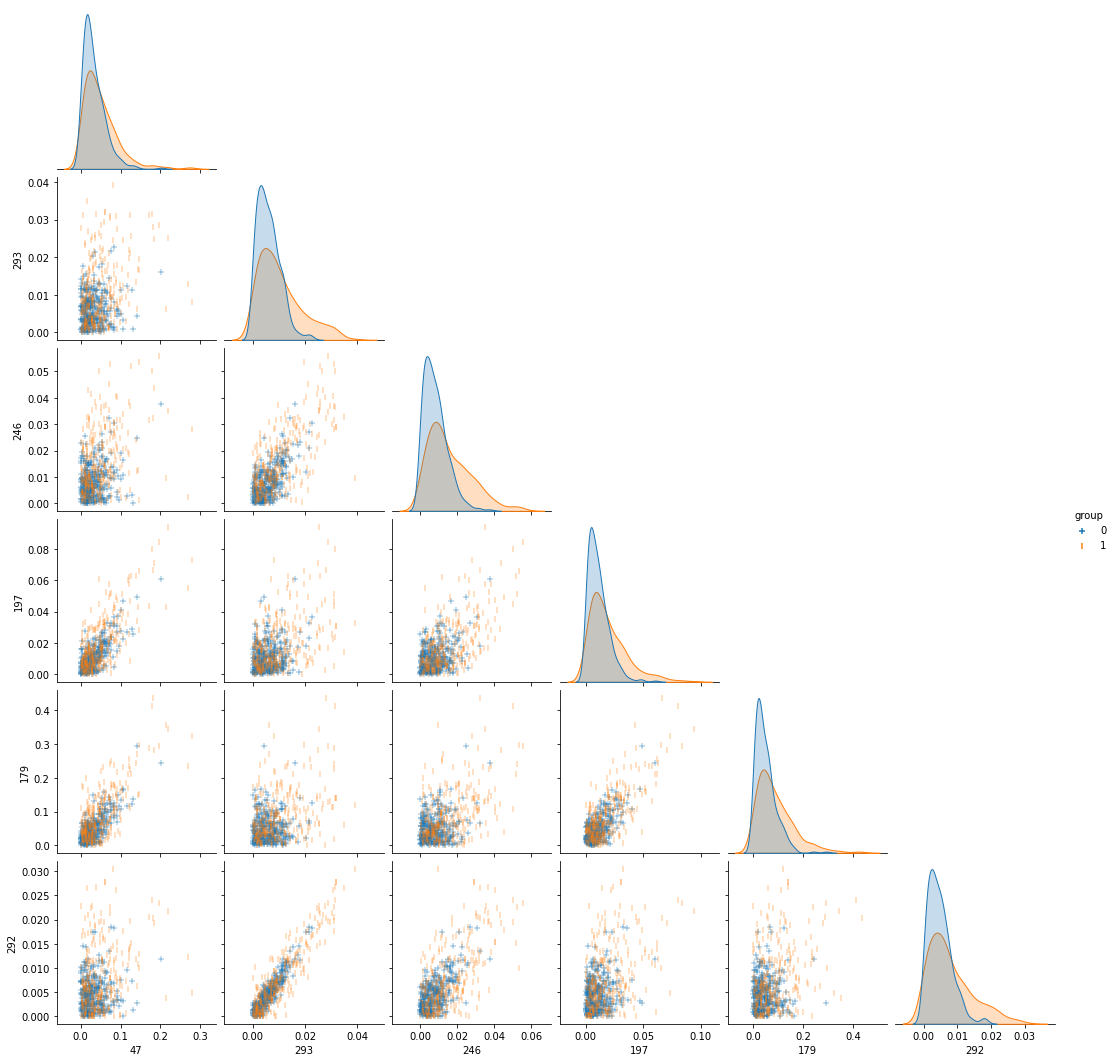

In [22]:
bar=dfpatients.mean(axis=1)
top7=np.argsort(-bar)[:7]
np.array(top7)
dflight=df.iloc[:,[0,48, 294, 247,198, 180, 293]]

sb.pairplot(dflight, hue='group', markers=["+","|"],corner=True)

# Scikit SVM classification for control vs patient

## splitting the dataset to training and testing datasets

In [23]:
# separating predictors and outcome y, 
y = np.array(df["group"])
x = np.array(df.drop(["group"],axis =1))

# Splitting the data into Train and Test (80-20)
xtrain, xtest, ytrain, ytest = skm.train_test_split(x,y,test_size=.2, random_state=0)


## A first pass comparisong of SVM Kernels before grid search, with some hyperparameter defaults

## since samples sizes are fairly close, we are not applying weights


In [24]:
# first pass SVM before grid search, with these defaults
# gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
svm_model=SVC(kernel='rbf',C= 1.0, gamma='scale')
svm_model.fit(xtrain,ytrain)
predict=svm_model.predict(xtrain)

#training performance
print(classification_report(ytrain,predict))
print(svm_model.score(xtrain,ytrain))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       242
           1       0.98      0.88      0.93       238

    accuracy                           0.93       480
   macro avg       0.94      0.93      0.93       480
weighted avg       0.94      0.93      0.93       480

0.93125


Linear Kernel with same training set and same parameters as the SVM with RBF Kernel above.

In [25]:
# set kernel to linear with same C and gamma as the rbf above.
C=svm_model.C
gamma= svm_model.gamma
print(f'C= {C}, gamma={gamma}')
svm_model=SVC(kernel='linear', C=C, gamma=gamma)
svm_model.fit(xtrain,ytrain)

predict=svm_model.predict(xtrain)

# training performance
print(classification_report(ytrain,predict))
print(svm_model.score(xtrain,ytrain))

C= 1.0, gamma=scale
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       242
           1       0.97      0.84      0.90       238

    accuracy                           0.91       480
   macro avg       0.92      0.91      0.91       480
weighted avg       0.92      0.91      0.91       480

0.9083333333333333


# Grid search for SVM optimization

Selected hyperparameters and kernel: {'C': 100, 'gamma': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       1.00      1.00      1.00       238

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



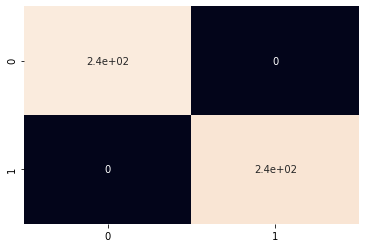

In [26]:
#The “balanced” mode uses the values of y to automatically adjust weights 
# inversely proportional to class frequencies in the input data as 
# n_samples / (n_classes * np.bincount(y))

param_grid={'C':[0.1,1,10,100],'gamma':[1,0.1,0.01,0.001],'kernel':['rbf','linear']}
grid=GridSearchCV(SVC(),param_grid,refit=True)
grid.fit(xtrain,ytrain)
print(f'Selected hyperparameters and kernel: {grid.best_params_}')

grid_predict=grid.predict(xtrain)

# Optimized training performance
print(classification_report(ytrain,grid_predict))
cm=confusion_matrix(ytrain,grid_predict)
ax=sb.heatmap(cm, cbar=False, annot=True)

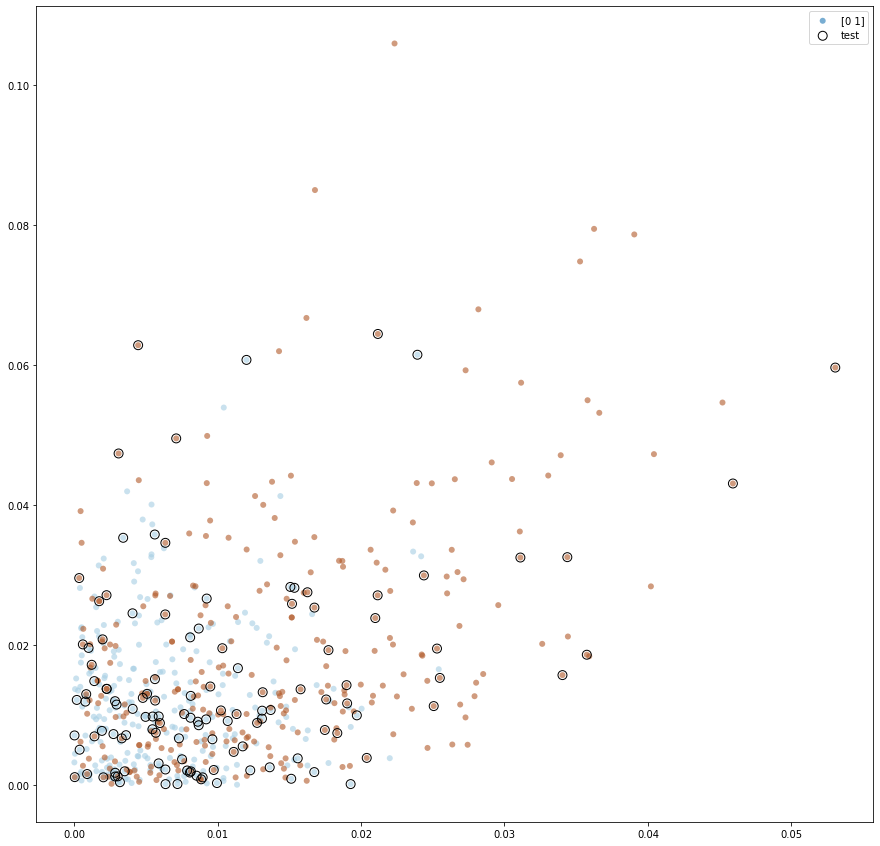

In [27]:
# plot the samples in two feature space
# selected features
svm_model=SVC(kernel='linear', C=100, gamma=1)
svm_model.fit(xtrain,ytrain)

a,b=247, 198

plt.figure(figsize=(15,15))
plt.clf()
plt.scatter(x[:, a], x[:, b], c=y, cmap=plt.cm.Paired, alpha=0.6, edgecolors='none',label=np.unique(y)  )
plt.scatter(xtest[:, a], xtest[:, b], s=80, facecolors='none', cmap=plt.cm.Paired, edgecolors='k',label="test")

# fix label in first plot to make 0 and 1
plt.legend()
# trying to draw the hyperplane for this pair of features only
#w = svm_model.coef_[0]
#sla = -w[0] / w[1]
#xx = np.linspace(0, .05)
#yy = sla * xx - (svm_model.intercept_[0]) / w[1]
#plt.plot(xx, yy, 'k-')


# Going to the test dataset with optimized SVM

the training may represent overfitting and may benefit from having a train-validation then test sequence for better optimization.

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        62
           1       0.91      0.88      0.90        59

    accuracy                           0.90       121
   macro avg       0.90      0.90      0.90       121
weighted avg       0.90      0.90      0.90       121



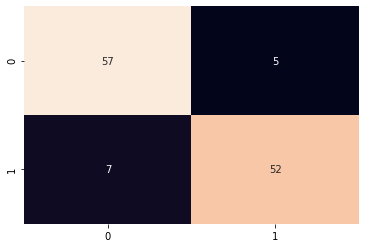

In [28]:
test_predict=grid.predict(xtest)
print(classification_report(ytest,test_predict))
cm=confusion_matrix(ytest,test_predict)
ax=sb.heatmap(cm, cbar=False, annot=True)

#PCA Stuff

In [29]:
def pcaInfo(xdata,ydata):
  '''
  xdata- feature data.
  ydata- label data.
  '''

  #Graph PCA features/variance.
  pca = PCA(random_state=123)
  pca.fit(xdata)
  features = range(pca.n_components_)
  transform = pca.transform(xdata)

  plt.figure(figsize=(8,4))
  plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
  plt.xlabel('PCA feature')
  plt.ylabel('Variance')
  plt.xticks(features[:15])
  plt.show()

  #Graph number of features/variance 
  n_components_array=([1,5,10,25,50,75,100])
  vr = np.zeros(len(n_components_array))
  i=0;
  for n_components in n_components_array:
      pca = PCA(n_components=n_components)
      pca.fit(xdata)
      vr[i] = sum(pca.explained_variance_ratio_)
      i=i+1  
      
  plt.figure(figsize=(8,4))
  plt.plot(n_components_array,vr,'k.-')
  #plt.xscale("log")
  plt.ylim(9e-2,1.1)
  #plt.yticks(linspace=(0.2,1.0,9))
  plt.xlim(0.9)
  plt.grid(which="both")
  plt.xlabel("number of PCA components",size=20)
  plt.ylabel("variance ratio",size=20)



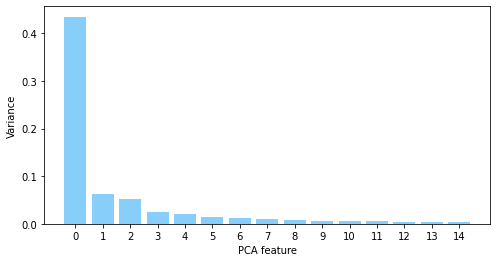

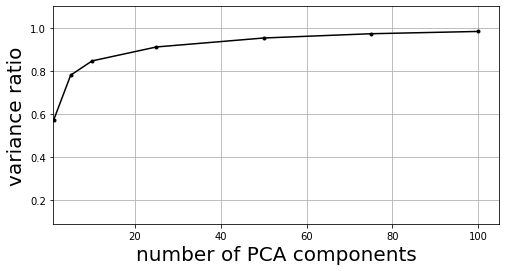

In [30]:
pcaInfo(x,y)

In [31]:
def runSVM(xdata, ydata, c,kern,gam,pca,comps):
  '''
  xd
  kern- kernel
  gam- gamme
  pca- bool true to use pca, false don't
  comps- number of features to use in pca.
  allx- x train and 
  '''
  if pca == False:#Do SVM without pca.
    xtrain, xtest, ytrain, ytest = skm.train_test_split(xdata,ydata,test_size=.2, random_state=0)

  else: #PCA SVM
    pca = PCA(n_components=comps)
    pca.fit(xdata)
    transform = pca.transform(xdata)
    xtrain, xtest, ytrain, ytest = skm.train_test_split(transform,ydata,test_size=.2, random_state=0)

  svm_model=SVC(kernel=kern, C=c, gamma=gam)
  svm_model.fit(xtrain,ytrain) #if PCA SVM features are components
  score = svm_model.predict(xtrain)
  print(classification_report(ytrain,score))
  ypred = svm_model.predict(xtest)
  print(classification_report(ytest,ypred))

  metrics.plot_roc_curve(svm_model, xtest, ytest)  
  plt.show()

SVM with PCA 

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       242
           1       0.96      0.91      0.94       238

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        62
           1       0.98      0.92      0.95        59

    accuracy                           0.95       121
   macro avg       0.95      0.95      0.95       121
weighted avg       0.95      0.95      0.95       121



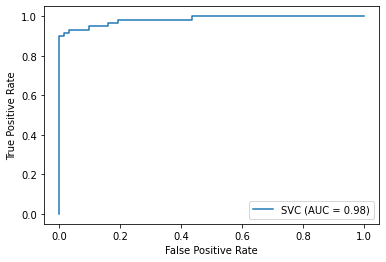

In [32]:
runSVM(x,y,100,"linear",1,True,25)

SVM w/o PCA

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       1.00      1.00      1.00       238

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        62
           1       0.91      0.88      0.90        59

    accuracy                           0.90       121
   macro avg       0.90      0.90      0.90       121
weighted avg       0.90      0.90      0.90       121



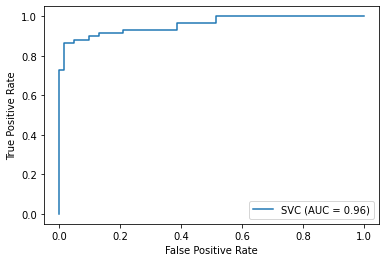

In [33]:
runSVM(x,y,100,"linear",1,False,100)

#Artifical Data Creation(unfinished). FUTURE WORK.


In [ ]:
def faceCompare(a,b,right):
  '''
  a-df of facial data(LI) to be edited
  b-df of facial data(LI) to compare to a.
  right- bool, true if comparing right fales if left.

  returns- bool true if a can be edited with b false if not.
  '''
  ale = a[36] #a left eye tip
  alm = a[48] #a left mouth tip
  are = a[45] #a right eye tip
  arm = a[54] #a right mouth tip

  ble = b[36]
  blm = b[48]
  bre = b[45]
  brm = b[54]

  if right:
    if are < bre or arm < brm:
      return True
    else:
      return False
  else:
    if ale < ble or alm < blm:
      return True
    else:
      return False

In [ ]:
def NewfaceEdit(a,b):
  '''
  Room to improve: if new lip lower than previous, slight change in 
  lower eye and lateral nose corner congruent with lip corner.

  a-face to be edited. Represented as pandas series(LI data).
  b-face to edit a with. Represented as a pandas series(LI data).
  
  ret- edited faced return by this function
  '''
  cols = [36,37,41,44,45,46,48,49,53,54,60,64]
  ret = a.copy()
  ret_i = ret.index.values[0]
  b_i = b.index.values[0]
  for x in cols:
    ret.iloc[x] = b.iloc[x]
  

  return ret

In [ ]:
def createArtifical(patient,control):
  '''
  Creates additional artifical data based on random observations
  from patient. Those observations are used to alter control observations.
  The resulting data is to be added to future control data sets.

  patient- dataframe of patient data.
  control- dataframe of control data. 

  Returns- list of dataframes containing additional artifical control data.
  '''
  percentage = 0.10
  maxpercentage = .50
  ret = []
  while percentage <= maxpercentage:
    #Get number of patients & controls equal to percentage of control values.
    num_to_get = round(len(control)*percentage)#number of observations to add.
    patient_samples = patient.sample(num_to_get)
    control_samples = control.sample(num_to_get)
    #alter control samples with patient samples.
    temp_ret = []
    while len(temp_ret) < num_to_get:
      index = randint(0,num_to_get-1)
      pface = patient_samples.iloc[index]
      cface = control_samples.iloc[index]
      side = randint(0,1)
      if faceCompare(cface,pface,side):#if meets criteria to edit.
        #edit face and add to temp_ret
        new_face = NewfaceEdit(cface,pface)
        temp_ret.append(new_face.copy())
    ret.append(temp_ret)
    percentage = percentage + 0.10
  return ret

For a new control data set concat results in an entry in results.